In [1]:
from matplotlib import pyplot as plt
import pandas as pd

from ccsblib import paros_connection
from ccsblib import ccsbplotlib as cplt

In [4]:
df = pd.read_csv('mN2H validation TFv02 - labels.tsv', sep='\t')
empty_col = 'empty_wells_after_LR (reading horizontally a1 to a12, then b1 to b12)'
df = df.dropna()
df = df.loc[df[empty_col] != 'There is no such plate', :]

def extract_positions(s):
    l = []
    for item in s.split(', '):
        if '-' in item:
            start = int(item.split('-')[0][1:])
            stop = int(item.split('-')[1][1:])
            for i in range(start, stop + 1):
                l.append(item[0] + str(i))
        else:
            l.append(item)
    return [x[0].upper() + x[1:].zfill(2) for x in l]

df['position'] = df[empty_col].apply(extract_positions)
df = df.explode('position')
df = df.loc[:, ['cp_entry_labels', 'position']]

In [3]:
# out of place
# look at overlap of redone plates
df = pd.read_csv('mN2H validation TFv02 - labels.tsv', sep='\t')
empty_col = 'empty_wells_after_LR (reading horizontally a1 to a12, then b1 to b12)'
empty_col_2 = 'empty_wells_2nd_attempt'
df = df.dropna()
df = df.loc[df[empty_col] != 'There is no such plate', :]

def extract_positions(s):
    l = []
    for item in s.split(', '):
        if '-' in item:
            start = int(item.split('-')[0][1:])
            stop = int(item.split('-')[1][1:])
            for i in range(start, stop + 1):
                l.append(item[0] + str(i))
        else:
            l.append(item)
    return [x[0].upper() + x[1:].zfill(2) for x in l]

df['first'] = df[empty_col].apply(extract_positions)
df['second'] = df[empty_col_2].apply(extract_positions)
df = pd.melt(df,
        id_vars='cp_entry_labels',
        value_vars=['first',
                    'second'],
        value_name='position',
        var_name='repeat')
df = df.explode('position')
qry = """select a.test_orf_id, a.node_pla_full, a.node_pos, b.src_collection, b.cds_len
from tf_validation.validation_nodes_1strnd as a
left join hi_ref.master_ref as b
on a.test_orf_id = b.orf_id
where a.config = 'B'
and standard_batch = 'Tfv02';"""
df = pd.merge(df, 
                pd.read_sql(qry, paros_connection()),
                how='right',
                left_on=['cp_entry_labels', 'position'],
                right_on=['node_pla_full', 'node_pos'])
df = df.loc[df['node_pla_full'].isin(['TFv02R1Eb002', 'TFv02R1Eb006', 'TFv02R1Eb007']), :]
df['repeat'] = df['repeat'].fillna('first')
df['is_missing'] = ~df['cp_entry_labels'].isnull()
df = df.pivot_table(index=['node_pla_full', 'node_pos'],
         values=['is_missing'],
         columns=['repeat']).sort_index()
df[('is_missing', 'first')] = df[('is_missing', 'first')].fillna(False)
df[('is_missing', 'second')] = df[('is_missing', 'second')].fillna(False)

UserWarning: Failed to connect to database.
Maybe you are outside the internal network and forgot to to start the VPN?

In [53]:
# out of place
# look at overlap of redone plates
df = pd.read_csv('mN2H validation TFv02 - labels.tsv', sep='\t')
empty_col = 'empty_wells_after_LR (reading horizontally a1 to a12, then b1 to b12)'
empty_col_2 = 'empty_wells_2nd_attempt'
df[empty_col_2] = df[empty_col_2].fillna('')
df = df.dropna()
df = df.loc[df[empty_col] != 'There is no such plate', :]

def extract_positions(s):
    if s == '':
        return []
    l = []
    for item in s.split(', '):
        if '-' in item:
            start = int(item.split('-')[0][1:])
            stop = int(item.split('-')[1][1:])
            for i in range(start, stop + 1):
                l.append(item[0] + str(i))
        else:
            l.append(item)
    return [x[0].upper() + x[1:].zfill(2) for x in l]

df['first'] = df[empty_col].apply(extract_positions)
df['second'] = df[empty_col_2].apply(extract_positions)
df = pd.melt(df,
        id_vars='cp_entry_labels',
        value_vars=['first',
                    'second'],
        value_name='position',
        var_name='repeat')
df = df.explode('position')
qry = """select a.test_orf_id, a.node_pla_full, a.node_pos, b.src_collection, b.cds_len, a.config
from tf_validation.validation_nodes_1strnd as a
left join hi_ref.master_ref as b
on a.test_orf_id = b.orf_id
where standard_batch = 'Tfv02';"""
df_first = pd.merge(df.loc[df['repeat'] == 'first', :], 
                pd.read_sql(qry, paros_connection()),
                how='right',
                left_on=['cp_entry_labels', 'position'],
                right_on=['node_pla_full', 'node_pos'])
df_first['repeat'] = df_first['repeat'].fillna('first')
df_second = pd.merge(df.loc[df['repeat'] == 'second', :], 
                pd.read_sql(qry, paros_connection()),
                how='right',
                left_on=['cp_entry_labels', 'position'],
                right_on=['node_pla_full', 'node_pos'])
df_second = df_second.loc[df_second['node_pla_full'].isin(['TFv02R1Eb002', 'TFv02R1Eb006', 'TFv02R1Eb007']), :]
df_second['repeat'] = df_second['repeat'].fillna('second')
df = pd.concat([df_first, df_second])
df['is_missing'] = ~df['cp_entry_labels'].isnull()

In [54]:
# problem: need to add not missing for 2nd plate
df.groupby(['repeat', 'node_pla_full'])['is_missing'].mean()

repeat  node_pla_full
first   TFv02R1Ea001     0.000000
        TFv02R1Ea002     0.000000
        TFv02R1Ea003     0.031915
        TFv02R1Ea004     0.052632
        TFv02R1Ea005     0.042553
        TFv02R1Ea006     0.031915
        TFv02R1Ea007     0.126316
        TFv02R1Ea008     0.074468
        TFv02R1Ea009     0.042105
        TFv02R1Ea010     0.106383
        TFv02R1Ea011     0.205882
        TFv02R1EaKan1    0.085714
        TFv02R1Eb001     0.000000
        TFv02R1Eb002     0.255319
        TFv02R1Eb003     0.159574
        TFv02R1Eb004     0.095745
        TFv02R1Eb005     0.126316
        TFv02R1Eb006     0.531915
        TFv02R1Eb007     0.287234
        TFv02R1Eb008     0.133333
        TFv02R1EbKan1    0.384615
second  TFv02R1Eb002     0.510638
        TFv02R1Eb006     0.425532
        TFv02R1Eb007     0.574468
Name: is_missing, dtype: float64

In [5]:
# set of N1 orfs and N2 orfs
n1_orf_ids = set(df.loc[~df['is_missing'] & (df['config'] == 'A'), 'test_orf_id'].astype(int).unique())
n2_orf_ids = set(df.loc[~df['is_missing'] & (df['config'] == 'B'), 'test_orf_id'].astype(int).unique())

KeyError: 'is_missing'

In [58]:
# read in the pairs with categories
qry = """select b.test_orf_ida, b.test_orf_idb, a.source
from tf_validation.validation_source as a
left join tf_validation.validation_configure as b
using (orf_id1, orf_id2, standard_batch)
where standard_batch = 'Tfv02';"""
df = pd.read_sql(qry, paros_connection())
df['both_orfs'] = df['test_orf_ida'].isin(n1_orf_ids) & df['test_orf_idb'].isin(n2_orf_ids)
print(df['test_orf_ida'].nunique(), len(n1_orf_ids))
print(df['test_orf_idb'].nunique(), len(n2_orf_ids))
print(df.groupby('source')['both_orfs'].mean())
print(df.groupby('source')['both_orfs'].sum())
# if true, test difference in degree of missing vs not missing

1009 951
746 640
source
TF_RRS                       0.729167
huri_rrs                     0.846667
isoform_matched_negatives    0.884146
isoform_negatives            0.900000
isoform_positives            0.813333
lit_bm_2013_rand250          0.805000
litbm                        0.692308
whole_tf_genes               0.748148
Name: both_orfs, dtype: float64
source
TF_RRS                       105.0
huri_rrs                     254.0
isoform_matched_negatives    145.0
isoform_negatives            135.0
isoform_positives            244.0
lit_bm_2013_rand250          161.0
litbm                         99.0
whole_tf_genes               101.0
Name: both_orfs, dtype: float64


In [60]:
qry = """select distinct test_orf_id, vector  from tf_validation.validation_nodes_final  ;  """
old = pd.read_sql(qry, paros_connection())
old.head()
n1_orf_ids_inc_old = n1_orf_ids.union(set(old.loc[old['vector'] == 'N1', 'test_orf_id'].unique()))
n2_orf_ids_inc_old = n2_orf_ids.union(set(old.loc[old['vector'] == 'N2', 'test_orf_id'].unique()))
df['both_orfs_inc_old'] = df['test_orf_ida'].isin(n1_orf_ids_inc_old) & df['test_orf_idb'].isin(n2_orf_ids_inc_old)
print(df.groupby('source')['both_orfs_inc_old'].mean())
print(df.groupby('source')['both_orfs_inc_old'].sum())


source
TF_RRS                       0.868056
huri_rrs                     0.980000
isoform_matched_negatives    0.957317
isoform_negatives            0.940000
isoform_positives            0.946667
lit_bm_2013_rand250          0.925000
litbm                        0.895105
whole_tf_genes               0.962963
Name: both_orfs_inc_old, dtype: float64
source
TF_RRS                       125.0
huri_rrs                     294.0
isoform_matched_negatives    157.0
isoform_negatives            141.0
isoform_positives            284.0
lit_bm_2013_rand250          185.0
litbm                        128.0
whole_tf_genes               130.0
Name: both_orfs_inc_old, dtype: float64


In [3]:
# count values
# test for relation
print(df.reset_index().groupby('node_pla_full').mean())
print('number successful ORFs in first attempt', (~df[('is_missing', 'first')]).sum())
print('out of ', df.shape[0])
print('number successfull combined 1st+2nd', (~df[('is_missing', 'first')] | ~df[('is_missing', 'second')]).sum())
print((~df[('is_missing', 'first')]).mean(), (~df[('is_missing', 'second')]).mean())
print((~df[('is_missing', 'first')] | ~df[('is_missing', 'second')]).mean())
res = df.groupby([('is_missing', 'first'), ('is_missing', 'second')]).size()
print(res)
from scipy import stats
print(stats.fisher_exact(res.values.reshape((2, 2))))
for plate in df.reset_index()['node_pla_full'].unique():
    print()
    print(plate)
    res = df.reset_index().loc[df.reset_index()['node_pla_full'] == plate, :].groupby([('is_missing', 'first'), ('is_missing', 'second')]).size()
    print(stats.fisher_exact(res.values.reshape((2, 2))))
    #print(res)

              is_missing          
repeat             first    second
node_pla_full                     
TFv02R1Eb002    0.255319  0.510638
TFv02R1Eb006    0.531915  0.425532
TFv02R1Eb007    0.287234  0.574468
number successful ORFs in first attempt 181
out of  282
number successfull combined 1st+2nd 227
0.6418439716312057 0.49645390070921985
0.8049645390070922
(is_missing, first)  (is_missing, second)
False                False                   94
                     True                    87
True                 False                   46
                     True                    55
dtype: int64
(1.2918540729635182, 0.3223280067398766)

TFv02R1Eb002
(1.8686868686868687, 0.24001129465769974)

TFv02R1Eb006
(1.6153846153846154, 0.2992186398064006)

TFv02R1Eb007
(1.1100478468899522, 1.0)


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [7]:
df.reset_index().loc[df.reset_index()['node_pla_full'] == 'TFv02R1Eb002', :].groupby([('is_missing', 'first'), ('is_missing', 'second')]).size()

(is_missing, first)  (is_missing, second)
False                False                   37
                     True                    33
True                 False                    9
                     True                    15
dtype: int64

In [140]:
# map to ORF ID
qry = """select a.test_orf_id, a.node_pla_full, a.node_pos, b.src_collection, b.cds_len
from tf_validation.validation_nodes_1strnd as a
left join hi_ref.master_ref as b
on a.test_orf_id = b.orf_id
where a.config = 'B'
and standard_batch = 'Tfv02';"""

#qry = """select test_orf_id, node_pla_full, node_pos
#from tf_validation.validation_nodes_1strnd
#where standard_batch = 'Tfv02';"""

df2 = pd.read_sql(qry, paros_connection())
df2.head()

,test_orf_id,node_pla_full,node_pos,src_collection,cds_len
0,100527,TFv02R1Eb007,F10,None,NaN
1,101254,TFv02R1Eb007,B11,None,NaN
2,101256,TFv02R1Eb007,A12,None,NaN
3,101414,TFv02R1Eb008,G09,None,NaN
4,100315,TFv02R1Eb007,A10,None,NaN


In [141]:
qry = """select orf_id, LENGTH(cds) as cds_len
from tf_screen.iso6k_sequences;"""
iso_cds_len = pd.read_sql(qry, paros_connection()).drop_duplicates().set_index('orf_id')['cds_len']
df2['cds_len'] = df2['cds_len'].fillna(df2['test_orf_id'].map(iso_cds_len))

In [142]:
df2.loc[(df2['test_orf_id'] > 100000) & (df2['test_orf_id'] < 110000), 'src_collection'] = 'Isoforms'

In [143]:
# ORF sizes of plate Eb006 rows F and G
df2.loc[(df2['node_pla_full'] == 'TFv02R1Eb006') &
        (df2['node_pos'].str.startswith('F') |
         df2['node_pos'].str.startswith('G')), 
         ['test_orf_id', 'node_pla_full', 'node_pos', 'cds_len']].sort_values('node_pos').to_csv('ORF-sizes-of-plate-Eb006-rows-F-and-G.tsv', sep='\t', index=False)

In [144]:
df = pd.merge(df, 
df2,
 how='inner',
  left_on=['cp_entry_labels', 'position'],
  right_on=['node_pla_full', 'node_pos'])

In [145]:
((df['test_orf_id'] > 100000) & (df['test_orf_id'] < 110000)).value_counts()

True     77
False    24
Name: test_orf_id, dtype: int64

In [146]:
((df2['test_orf_id'] > 100000) & (df2['test_orf_id'] < 110000)).value_counts()

False    479
True     268
Name: test_orf_id, dtype: int64

In [147]:
df['src_collection'].value_counts()

Isoforms    77
1.1         14
3.1          5
5.1          3
7.1          2
Name: src_collection, dtype: int64

In [148]:
df2['src_collection'].value_counts()

Isoforms    268
1.1         222
3.1          85
5.1          66
7.1          64
OCAB         29
OCAA         13
Name: src_collection, dtype: int64

In [149]:
df['src_collection'].value_counts() / df2['src_collection'].value_counts()

1.1         0.063063
3.1         0.058824
5.1         0.045455
7.1         0.031250
Isoforms    0.287313
OCAA             NaN
OCAB             NaN
Name: src_collection, dtype: float64

In [150]:
df2 = pd.merge(df, 
df2,
 how='right',
  left_on=['cp_entry_labels', 'position'],
  right_on=['node_pla_full', 'node_pos'])
df2['is_missing'] = ~df2['cp_entry_labels'].isnull()

In [153]:
df2.head()

,cp_entry_labels,position,test_orf_id_x,node_pla_full_x,node_pos_x,src_collection_x,cds_len_x,test_orf_id_y,node_pla_full_y,node_pos_y,src_collection_y,cds_len_y,is_missing
0,TFv02R1Eb002,A01,7684.0,TFv02R1Eb002,A01,1.1,2208.0,7684,TFv02R1Eb002,A01,1.1,2208.0,True
1,TFv02R1Eb002,B05,6449.0,TFv02R1Eb002,B05,1.1,597.0,6449,TFv02R1Eb002,B05,1.1,597.0,True
2,TFv02R1Eb002,B10,53018.0,TFv02R1Eb002,B10,5.1,1446.0,53018,TFv02R1Eb002,B10,5.1,1446.0,True
3,TFv02R1Eb002,B12,56353.0,TFv02R1Eb002,B12,5.1,4647.0,56353,TFv02R1Eb002,B12,5.1,4647.0,True
4,TFv02R1Eb002,C03,4361.0,TFv02R1Eb002,C03,1.1,960.0,4361,TFv02R1Eb002,C03,1.1,960.0,True


In [154]:
df2.loc[df2['node_pla_full_y'].isin(['TFv02R1Eb002', 'TFv02R1Eb006', 'TFv02R1Eb007']), 'src_collection_y'].value_counts()

Isoforms    188
1.1          51
3.1          19
5.1          11
7.1           8
OCAB          5
Name: src_collection_y, dtype: int64

In [23]:
df2.groupby('cp_entry_labels')['is_missing'].sum().sum()

152.0

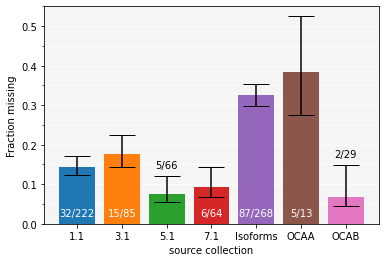

In [50]:
collections = sorted(df2['src_collection_y'].unique())
cplt.validation_plot(data=df2,
                     result_column='is_missing',
                     selections=[df2['src_collection_y'] == x for x in collections],
                     labels=collections,
                     errorbar_capsize=0.1)
plt.ylabel('Fraction missing')
plt.ylim(0, 0.55)
plt.xlabel('source collection')
plt.savefig('../figures/missing_clones_by_collection.pdf', bbox_inches='tight')

In [52]:
df2.head()

,cp_entry_labels,position,test_orf_id_x,node_pla_full_x,node_pos_x,src_collection_x,cds_len_x,test_orf_id_y,node_pla_full_y,node_pos_y,src_collection_y,cds_len_y,is_missing
0,TFv02R1Eb002,A01,7684.0,TFv02R1Eb002,A01,1.1,2208.0,7684,TFv02R1Eb002,A01,1.1,2208.0,True
1,TFv02R1Eb002,B05,6449.0,TFv02R1Eb002,B05,1.1,597.0,6449,TFv02R1Eb002,B05,1.1,597.0,True
2,TFv02R1Eb002,B10,53018.0,TFv02R1Eb002,B10,5.1,1446.0,53018,TFv02R1Eb002,B10,5.1,1446.0,True
3,TFv02R1Eb002,B12,56353.0,TFv02R1Eb002,B12,5.1,4647.0,56353,TFv02R1Eb002,B12,5.1,4647.0,True
4,TFv02R1Eb002,C03,4361.0,TFv02R1Eb002,C03,1.1,960.0,4361,TFv02R1Eb002,C03,1.1,960.0,True


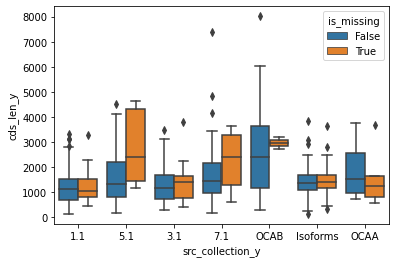

In [58]:
# correlation between size of ORF and dropout
import seaborn as sns

sns.boxplot(data=df2,
              y='cds_len_y',
              x='src_collection_y',
              hue='is_missing')
plt.savefig('../figures/missing-clones_by-length.pdf',
            bbox_inches='tight')

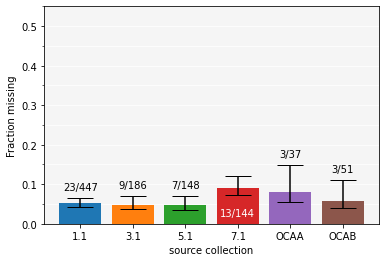

In [3]:
df = pd.read_csv('mN2H validation TFv02 - labels.tsv', sep='\t')
empty_col = 'empty_wells_after_LR (reading horizontally a1 to a12, then b1 to b12)'
df = df.dropna()
df = df.loc[df[empty_col] != 'There is no such plate', :]

def extract_positions(s):
    l = []
    for item in s.split(', '):
        if '-' in item:
            start = int(item.split('-')[0][1:])
            stop = int(item.split('-')[1][1:])
            for i in range(start, stop + 1):
                l.append(item[0] + str(i))
        else:
            l.append(item)
    return [x[0].upper() + x[1:].zfill(2) for x in l]

df['position'] = df[empty_col].apply(extract_positions)
df = df.explode('position')
df = df.loc[:, ['cp_entry_labels', 'position']]

qry = """select a.test_orf_id, a.node_pla_full, a.node_pos, b.src_collection
from tf_validation.validation_nodes_1strnd as a
left join hi_ref.master_ref as b
on a.test_orf_id = b.orf_id
where a.config = 'A'
and standard_batch = 'Tfv02';"""
df2 = pd.read_sql(qry, paros_connection())
df2.loc[(df2['test_orf_id'] > 100000) & (df2['test_orf_id'] < 110000), 'src_collection'] = 'Isoforms'

df = pd.merge(df, 
df2,
 how='inner',
  left_on=['cp_entry_labels', 'position'],
  right_on=['node_pla_full', 'node_pos'])

df2 = pd.merge(df, 
df2,
 how='right',
  left_on=['cp_entry_labels', 'position'],
  right_on=['node_pla_full', 'node_pos'])
df2['is_missing'] = ~df2['cp_entry_labels'].isnull()

collections = sorted(df2['src_collection_y'].unique())
cplt.validation_plot(data=df2,
                     result_column='is_missing',
                     selections=[df2['src_collection_y'] == x for x in collections],
                     labels=collections,
                     errorbar_capsize=0.1)
plt.ylabel('Fraction missing')
plt.ylim(0, 0.55)
plt.xlabel('source collection')
plt.savefig('../figures/missing_clones_by_collection_N1.pdf', bbox_inches='tight')
